# База данных «Абитуриент», запросы корректировки

### 118

Создать вспомогательную таблицу applicant,  куда включить id образовательной программы, id абитуриента, сумму баллов абитуриентов (столбец itog) в отсортированном сначала по id образовательной программы, а потом по убыванию суммы баллов виде (использовать запрос из предыдущего урока).

Фрагмент структуры данных:

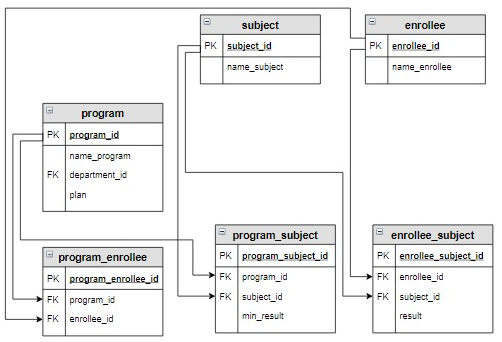

In [ ]:
CREATE TABLE applicant AS
SELECT program.program_id, 
       enrollee.enrollee_id, 
       SUM(result) AS itog
  FROM enrollee JOIN program_enrollee
       ON enrollee.enrollee_id = program_enrollee.enrollee_id
       JOIN program
       ON program_enrollee.program_id = program.program_id
       JOIN program_subject
       ON program.program_id = program_subject.program_id
       JOIN subject
       ON subject.subject_id = program_subject.subject_id
       JOIN enrollee_subject
       ON enrollee_subject.subject_id = subject.subject_id
       AND enrollee_subject.enrollee_id = enrollee.enrollee_id
 GROUP BY program.program_id, enrollee.enrollee_id
 ORDER BY program.program_id, itog DESC;

SELECT *
  FROM applicant;

### 119

Из таблицы applicant, созданной на предыдущем шаге, удалить записи, если абитуриент на выбранную образовательную программу не набрал минимального балла хотя бы по одному предмету (использовать запрос из предыдущего урока).

Фрагмент структуры данных:

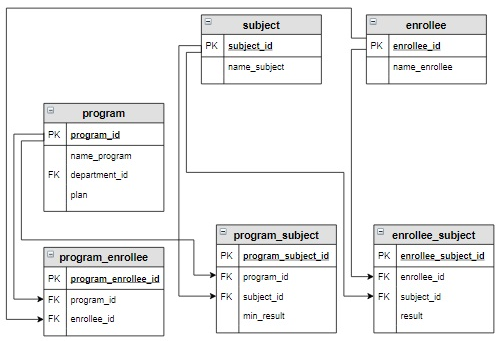

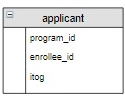

In [ ]:
DELETE FROM applicant
WHERE (program_id, enrollee_id) IN (
SELECT DISTINCT program.program_id, enrollee.enrollee_id
FROM enrollee JOIN program_enrollee
     ON enrollee.enrollee_id = program_enrollee.enrollee_id
     JOIN program
     ON program_enrollee.program_id = program.program_id
     JOIN program_subject
     ON program.program_id = program_subject.program_id
     JOIN subject
     ON subject.subject_id = program_subject.subject_id
     JOIN enrollee_subject
     ON enrollee_subject.subject_id = subject.subject_id
     AND enrollee_subject.enrollee_id = enrollee.enrollee_id
where result < min_result
GROUP BY program.program_id, enrollee.enrollee_id
ORDER BY program.program_id, itog DESC);

SELECT *
FROM applicant;

### 120

Повысить итоговые баллы абитуриентов в таблице `applicant` на значения дополнительных баллов (использовать запрос из предыдущего урока).

Фрагмент структуры данных:

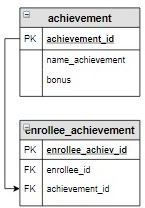

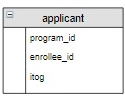

In [ ]:
UPDATE applicant JOIN (SELECT enrollee.enrollee_id, 
                              IF(SUM(bonus) IS NULL, 0, SUM(bonus)) AS Бонус
                         FROM enrollee LEFT JOIN enrollee_achievement
                              ON enrollee.enrollee_id = enrollee_achievement.enrollee_id
                              LEFT JOIN achievement
                              ON enrollee_achievement.achievement_id = achievement.achievement_id
                        GROUP BY enrollee_id
                        ORDER BY enrollee_id) AS sq
       ON applicant.enrollee_id = sq.enrollee_id
   SET itog = itog + Бонус;

SELECT *
FROM applicant;

### 121

Поскольку при добавлении дополнительных баллов, абитуриенты по каждой образовательной программе могут следовать не в порядке убывания суммарных баллов, необходимо создать новую таблицу `applicant_order` на основе таблицы `applicant`. При создании таблицы данные нужно отсортировать сначала по id образовательной программы, потом по убыванию итогового балла. А таблицу `applicant`, которая была создана как вспомогательная, необходимо удалить.

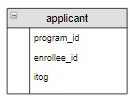

In [ ]:
CREATE TABLE applicant_order AS
SELECT *
  FROM applicant
 ORDER BY program_id, itog DESC;

  DROP TABLE applicant;

### 122

Включить в таблицу `applicant_order` новый столбец str_id целого типа, расположить его перед первым.

Корректируемая таблица:

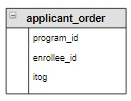

In [ ]:
ALTER TABLE applicant_order ADD str_id INT FIRST;

SELECT *
  FROM applicant_order;

### 123

Занести в столбец str_id таблицы `applicant_order` нумерацию абитуриентов, которая начинается с 1 для каждой образовательной программы.

Фрагмент структуры данных:

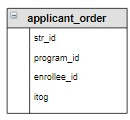

In [ ]:
SET @row_num := 1;
SET @num_pr := 0;
UPDATE applicant_order
   SET str_id = IF(program_id = @num_pr, @row_num := @row_num + 1, @row_num := 1 AND @num_pr := @num_pr + 1);

### 124

Создать таблицу `student`,  в которую включить абитуриентов, которые могут быть рекомендованы к зачислению  в соответствии с планом набора. Информацию отсортировать сначала в алфавитном порядке по названию программ, а потом по убыванию итогового балла.

Фрагмент структуры данных:

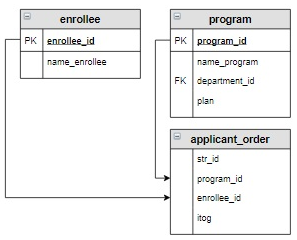

In [ ]:
CREATE TABLE student AS
SELECT name_program, 
       name_enrollee, 
       itog 
  FROM enrollee JOIN applicant_order
       ON enrollee.enrollee_id = applicant_order.enrollee_id
       JOIN program
       ON applicant_order.program_id = program.program_id
 WHERE str_id <= plan
 ORDER BY name_program, itog DESC;

SELECT *
  FROM student;